# Primal optimisation with mapped features

Here, we apply the same logic as the previous notebook, but we start by mapping the features thanks to a kernel function. 

The RandomFourrierFeatureMapper is an approximation of the RBG implicit map, which maps to infinite dimensions.

Along with our C, two new hyperparameters appear: the map output dimensions and the RFFM stddev.

Take note that the center is now in the higher-dimentional space.

In [76]:
import tensorflow as tf
import sys
import numpy as np

MAP_DIMS = 2000
DIMS = 2
INPUTS_NBR = 100
FRAC_ERR = 0.0007

R = tf.Variable(tf.random_normal([], mean=10), dtype=tf.float32, name="Radius")
a = tf.Variable(tf.random_normal([MAP_DIMS], mean=5), dtype=tf.float32, name="Center")

X = tf.placeholder(tf.float32, shape=(None, DIMS), name="X")
C = tf.constant(1.0/(INPUTS_NBR*FRAC_ERR), dtype=tf.float32)


kernel_mapper = tf.contrib.kernel_methods.RandomFourierFeatureMapper(
        input_dim=DIMS,
        output_dim=MAP_DIMS,
        stddev=10,
        name="rffm"
    )
mapped_X = kernel_mapper.map(X)

The loss is unchanged.

In [77]:
constraint = tf.square(R) - tf.square(tf.norm(mapped_X - a, axis=1))
loss = tf.square(R) - C * tf.reduce_sum(tf.minimum(constraint, 0.0))
loss = tf.reduce_sum(loss)

The train loop is unchanged. Here we added some validation data.

In [78]:
optimizer = tf.train.AdamOptimizer(0.1)
train = optimizer.minimize(loss)

EPOCHS = 10000

x_train = np.random.multivariate_normal(mean=[1., 1.], cov=np.eye(2), size=INPUTS_NBR).astype(np.float32)
x_eval = np.vstack([
    np.random.multivariate_normal(mean=[1., 1.], cov=np.eye(2), size=950).astype(np.float32),
    np.random.multivariate_normal(mean=[10., 10.], cov=np.eye(2), size=50).astype(np.float32),
])
    
    
sess = tf.InteractiveSession()

sess.run(tf.global_variables_initializer())
for e in range(EPOCHS):
    _, l, R1, a1 = sess.run([train, loss, R, a], feed_dict={X: x_train})

    towrite = "\r{0:4.1f} %, Loss: {1:7.4f}, R: {2:7.4f}".format(e / EPOCHS * 100, l, R1)
    sys.stdout.write(towrite)
    sys.stdout.flush()

100.0 %, Loss:  0.1118, R:  0.334487665

Run the evaluation and plot it.

In [79]:
eval_y = tf.sign(tf.square(R) - tf.square(tf.norm(mapped_X - a, axis=1)))

result = sess.run(eval_y, feed_dict={X: x_eval})

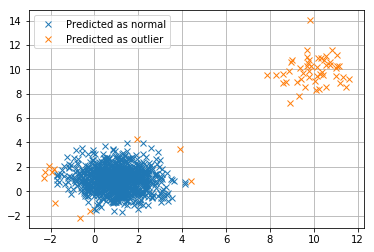

In [80]:
import matplotlib.pyplot as plt

ind_normal = result > 0
ind_outlier = result < 0
plt.plot(x_eval[ind_normal, 0], x_eval[ind_normal, 1], "x", label="Predicted as normal")
plt.plot(x_eval[ind_outlier, 0], x_eval[ind_outlier, 1], "x", label="Predicted as outlier")
plt.legend()
g = plt.grid()
plt.show()